# Noisy QCNN Fashion MNIST

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tak/Downloads/QEmbedding/')
import torch
from torch import nn
import pennylane as qml
import embedding
import data
from qiskit.providers.fake_provider import FakeJakarta
from qiskit_aer.noise import NoiseModel


noisy = FakeJakarta()
noise_model = NoiseModel.from_backend(noisy)
coupling_map = noisy.configuration().coupling_map
basis_gates = noise_model.basis_gates

dev_fake = qml.device(
    'qiskit.aer',
    wires=4,
    shots=1024,
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

# NQE Optimization

In [2]:
@qml.qnode(dev_fake, interface="torch")
def Four_circuit2(inputs): 
    embedding.Noisy_Four_QuantumEmbedding2(inputs[0:7])
    embedding.Noisy_Four_QuantumEmbedding2_inverse(inputs[7:14])
    return qml.probs(wires=range(4))

class PCA_NQE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(Four_circuit2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack2(x1)
        x2 = self.linear_relu_stack2(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer2(x)
        return x[:,0]


class NQE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(Four_circuit2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x1, x2):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = x2.view(-1, 7 * 7)
        x2 = self.fc(x2)

        x = torch.concat([x1, x2], 1)
        x = self.qlayer3(x)
        return x[:,0]

In [3]:
def new_data(batch_size, X, Y, feature_reduction):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)

    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    if feature_reduction == False:
        X1_new = X1_new.permute(0, 3, 1, 2)
        X2_new = X2_new.permute(0, 3, 1, 2)
    return X1_new, X2_new, Y_new

def train_models(model_name, X_train, Y_train, feature_reduction):
    if model_name == 'PCA-NQE':
        model = PCA_NQE()
    elif model_name == 'NQE':
        model = NQE()

    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(501):

        X1_batch, X2_batch, Y_batch = new_data(25, X_train, Y_train, feature_reduction)
        X1_batch, X2_batch, Y_batch = X1_batch, X2_batch, Y_batch

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 50 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
            PATH = f'{model_name}{it}.pt'
            torch.save(model.state_dict(), PATH)


In [ ]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
train_models('PCA-NQE', X_train, Y_train, feature_reduction)

In [4]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
train_models('NQE', X_train, Y_train, feature_reduction)

/tmp/ipykernel_291352/1218021825.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)


Iterations: 0 Loss: 0.35928454995155334
Iterations: 50 Loss: 0.6112101078033447


# QCNN Training

In [2]:
batch_size = 128
steps = 1000
ansatz = "TTN"
learning_rate = 0.01

In [3]:

class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

model2 = x_transform2()
model3 = x_transform3()

In [4]:
def statepreparation(x, Trained):
    if Trained == False:
        embedding.Noisy_Four_QuantumEmbedding1(x)
    elif Trained == 'PCA-NQE':
        model2.load_state_dict(torch.load('PCA-NQE500.pt'))
        x = model2(torch.tensor(x))
        embedding.Noisy_Four_QuantumEmbedding2(x)
    elif Trained == 'NQE':
        model3.load_state_dict(torch.load('NQE500.pt'))
        x = model3(torch.tensor(x))
        embedding.Noisy_Four_QuantumEmbedding2(x[0])


@qml.qnode(dev_fake)
def QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    embedding.Noisy_QCNN_four(params, ansatz)
    return qml.expval(qml.PauliZ(2))


def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)


def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)


def circuit_training(X_train, Y_train, Trained):

    if ansatz == 'SU4':
        num_weights = 30
    elif ansatz == 'TTN':
        num_weights = 4

    weights = np.random.random(num_weights, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 200 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

In [ ]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
#X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [ ]:
Loss_histories_not_trained, weights_not_trained, Loss_histories_Model2_Fidelity, weights_Model2_Fidelity = [], [], [], []
for i in range(5):
    loss_not_trained, weight_not_trained = circuit_training(X_train, Y_train, False)
    loss_Model2_Fidelity, weight_Model2_Fidelity = circuit_training(X_train, Y_train, 'PCA-NQE')

    Loss_histories_not_trained.append(loss_not_trained)
    Loss_histories_Model2_Fidelity.append(loss_Model2_Fidelity)

    weights_not_trained.append(weight_not_trained)
    weights_Model2_Fidelity.append(weight_Model2_Fidelity)

    
f = open('weights and losses.txt', 'a')
for i in range(5):
    f.write(f'Loss History without NQE {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_not_trained[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights without NQE {i + 1}:')
    f.write('\n')
    f.write(str(weights_not_trained[i]))



for i in range(5):
    f.write(f'Loss History with PCA-NQE {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_Model2_Fidelity[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights with PCA-NQE {i + 1}:')
    f.write('\n')
    f.write(str(weights_Model2_Fidelity[i]))
f.close()

In [ ]:
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2).detach().numpy(), X_test.permute(0, 3, 1, 2).detach().numpy()
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [ ]:
Loss_histories_Model3_Fidelity, weights_Model3_Fidelity = [], []
for i in range(5):

    loss_Model3_Fidelity, weight_Model3_Fidelity = circuit_training(X_train, Y_train, 'NQE')

    Loss_histories_Model3_Fidelity.append(loss_Model3_Fidelity)
    weights_Model3_Fidelity.append(weight_Model3_Fidelity)

f = open('weights and losses.txt', 'a')
for i in range(5):
    f.write(f'Loss History with NQE {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_Model3_Fidelity[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights with NQE{i + 1}:')
    f.write('\n')
    f.write(str(weights_Model3_Fidelity[i]))
f.close()

# Trace Distance History

In [16]:
PATHs_Model2, PATHs_Model3 = [], []

for i in range(11):
    PATH_Model2 = f'PCA-NQE{i * 50}.pt'
    PATH_Model3 = f'NQE{i * 50}.pt'

    PATHs_Model2.append(PATH_Model2)
    PATHs_Model3.append(PATH_Model3)

In [17]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev, interface="torch")
def Circuit_Distance1(inputs): 
    embedding.Noisy_Four_QuantumEmbedding1(inputs)
    return qml.density_matrix(wires=range(4))

@qml.qnode(dev, interface="torch")
def Circuit_Distance2(inputs): 
    embedding.Noisy_Four_QuantumEmbedding2(inputs)
    return qml.density_matrix(wires=range(4))


class Distances1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(Circuit_Distance1, weight_shapes={})
   
    def forward(self, x1, x0):
        rhos1 = self.qlayer1(x1)
        rhos0 = self.qlayer1(x0)

        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
    
class Distances2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(Circuit_Distance2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x0):
        x1 = self.linear_relu_stack2(x1)
        x0 = self.linear_relu_stack2(x0)
        rhos1 = self.qlayer2(x1)
        rhos0 = self.qlayer2(x0)

        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


class Distances3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(Circuit_Distance2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
    
    def forward(self, x1, x0):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x0 = self.layer1(x0)
        x0 = self.layer2(x0)
        x0 = x0.view(-1, 7 * 7)
        x0 = self.fc(x0)

        rhos1 = self.qlayer3(x1)
        rhos0 = self.qlayer3(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


def D(PATH, Model, X1, X0):
    if Model == 'Model2':
        Distance = Distances2()
    elif Model == 'Model3':
        Distance = Distances3()
    
    Distance.load_state_dict(torch.load(PATH))
    return Distance(X1, X0)

Model1

In [18]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)

/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_14237/916107762.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)


In [19]:
Distance = Distances1()
Model1_Train_Distance = Distance(X0_train, X1_train)
Model1_Test_Distance = Distance(X0_test, X1_test)

/Users/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/qnn/torch.py:331: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:276.)
  return res.type(x.dtype)


In [20]:
f = open("Trace Distance History.txt", 'a')
f.write("Without NQE Train Data: \n")
f.write(str(Model1_Train_Distance))
f.write("\n")
f.write("Without NQE Test Data: \n")
f.write(str(Model1_Test_Distance))
f.write("\n")
f.close()

Model2

In [21]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)

In [22]:
Trace_Distance_history_Model2_Train = [D(PATH=p, Model='Model2', X1=X1_train, X0=X0_train).detach().numpy() for p in PATHs_Model2]
Trace_Distance_history_Model2_Test = [D(PATH=p, Model='Model2', X1=X1_test, X0=X0_test).detach().numpy() for p in PATHs_Model2]

In [23]:
f = open("Trace Distance History.txt", 'a')
f.write("PCA-NQE Train Data: \n")
f.write(str(Trace_Distance_history_Model2_Train))
f.write("\n")
f.write("PCA-NQE Test Data: \n")
f.write(str(Trace_Distance_history_Model2_Test))
f.write("\n")
f.close()

Model3

In [24]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)
X1_test, X0_test = X1_test.permute(0, 3, 1, 2), X0_test.permute(0, 3, 1, 2)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)
X1_train, X0_train = X1_train.permute(0, 3, 1, 2), X0_train.permute(0, 3, 1, 2)

In [25]:
Trace_Distance_history_Model3_Train = [D(PATH=p, Model='Model3', X1=X1_train, X0=X0_train).detach().numpy() for p in PATHs_Model3]
Trace_Distance_history_Model3_Test = [D(PATH=p, Model='Model3', X1=X1_test, X0=X0_test).detach().numpy() for p in PATHs_Model3]

In [26]:
f = open("Trace Distance History.txt", 'a')
f.write("NQE Train Data: \n")
f.write(str(Trace_Distance_history_Model3_Train))
f.write("\n")
f.write("NQE Test Data: \n")
f.write(str(Trace_Distance_history_Model3_Test))
f.write("\n")
f.close()

# Part 4: Result 

Load the results

In [2]:
def data_read(PATH):
  textfile = open(PATH, 'r')
  data = np.array([])
  for line in textfile:
    a = np.array([float(v) for v in line.strip().split(" ")])
    data = np.append(data, a)
  return data

Loss_histories = data_read("Loss History.txt").reshape(3, 5000)
Loss_histories_not_trained = Loss_histories[0].reshape(5,1000)
Loss_histories_Model2 = Loss_histories[1].reshape(5,1000)
Loss_histories_Model3 = Loss_histories[2].reshape(5,1000)


Weights = data_read("Weights.txt").reshape(3, 5 * 4)
weights_not_trained = Weights[0].reshape(5, 4)
weights_Model2 = Weights[1].reshape(5, 4)
weights_Model3 = Weights[2].reshape(5, 4)


LH0_mean, LH0_std = Loss_histories_not_trained.mean(axis=0), Loss_histories_not_trained.std(axis=0)
LH2_mean, LH2_std = Loss_histories_Model2.mean(axis=0), Loss_histories_Model2.std(axis=0)
LH3_mean, LH3_std = Loss_histories_Model3.mean(axis=0), Loss_histories_Model3.std(axis=0)

In [3]:
LB_without_NQE = 0.5 * (1 - 0.3554)
LB_with_PCA_NQE = 0.5 * (1 - 0.7652531)
LB_with_NQE = 0.5 * (1 - 0.54707503)

Plot the results for Model 1,2,3

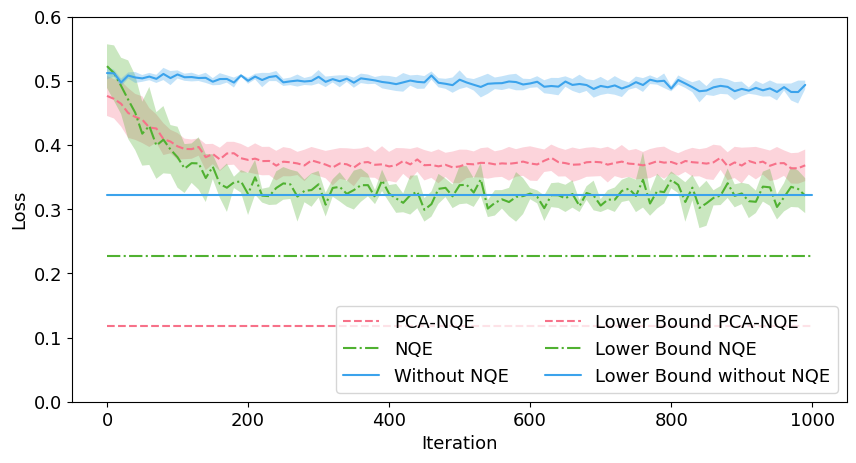

In [4]:
import seaborn as sns
n = 10
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):    
    ax.plot(np.array(range(len(LH2_mean[::n]))) * n, LH2_mean[::n], label="PCA-NQE", linestyle='dashed', c=clrs[0])
    ax.fill_between(np.array(range(len(LH2_mean[::n]))) * n, LH2_mean[::n]-LH2_std[::n], LH2_mean[::n]+LH2_std[::n], alpha=0.3,facecolor=clrs[0])

    ax.plot(np.array(range(len(LH3_mean[::n]))) * n, LH3_mean[::n], label="NQE", linestyle='dashdot', c=clrs[1])
    ax.fill_between(np.array(range(len(LH3_mean[::n]))) * n, LH3_mean[::n]-LH3_std[::n], LH3_mean[::n]+LH3_std[::n], alpha=0.3,facecolor=clrs[1])

    ax.plot(np.array(range(len(LH0_mean[::n]))) * n, LH0_mean[::n], label="Without NQE", linestyle='solid', c=clrs[2])
    ax.fill_between(np.array(range(len(LH0_mean[::n]))) * n, LH0_mean[::n]-LH0_std[::n], LH0_mean[::n]+LH0_std[::n], alpha=0.3,facecolor=clrs[2])


   
    ax.plot(range(1000), np.ones(1000) * LB_with_PCA_NQE, linestyle='dashed', linewidth=1.5, label="Lower Bound PCA-NQE", c=clrs[0])
    ax.plot(range(1000), np.ones(1000) * LB_with_NQE, linestyle='dashdot', linewidth=1.5, label="Lower Bound NQE", c=clrs[1])
    ax.plot(range(1000), np.ones(1000) * LB_without_NQE, linestyle='solid', linewidth=1.5, label="Lower Bound without NQE", c=clrs[2])


ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
#ax.set_title("Fashion MNIST Noisy QCNN Loss History")
ax.legend(fontsize=13, ncol=2, loc=4)
ax.set_ylim((0.0,0.6))
plt.savefig("Loss History.pdf")

Calculate the classification accuracies for Model1,2

In [32]:
feature_reduction = 'PCA4'
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [39]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_not_trained, accuracies_Model2_Fidelity = [], []

for i in range(5):
    prediction_not_trained = [QCNN_classifier(weights_not_trained[i], x, Trained=False) for x in X_test]
    prediction_Model2_Fidelity = [QCNN_classifier(weights_Model2[i], x, Trained='PCA-NQE') for x in X_test]
    
    accuracy_not_trained = accuracy_test(prediction_not_trained, Y_test)
    accuracy_Model2_Fidelity = accuracy_test(prediction_Model2_Fidelity, Y_test)

    accuracies_not_trained.append(accuracy_not_trained)
    accuracies_Model2_Fidelity.append(accuracy_Model2_Fidelity)

accuracies_not_trained = np.array(accuracies_not_trained)
accuracies_Model2_Fidelity = np.array(accuracies_Model2_Fidelity)

/Users/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_14237/919293247.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model2(torch.tensor(x))


Calculate the accuracies for Model 3

In [40]:
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [41]:
accuracies_Model3_Fidelity = []

for i in range(5):
    prediction_Model3_Fidelity = [QCNN_classifier(weights_Model3[i], x, Trained='NQE') for x in X_test]
    accuracy_Model3_Fidelity = accuracy_test(prediction_Model3_Fidelity, Y_test)
    accuracies_Model3_Fidelity.append(accuracy_Model3_Fidelity)

accuracies_Model3_Fidelity =np.array(accuracies_Model3_Fidelity)

/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_14237/919293247.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = model3(torch.tensor(x))


In [42]:

print("Noisy QCNN classification accuracies:\n")
print("-------------------------------------\n")
print(f" Accuracy without NQE: {accuracies_not_trained.mean()} ± {accuracies_not_trained.std()}")
print(f" Accuracy with PCA-NQE: {accuracies_Model2_Fidelity.mean()} ± {accuracies_Model2_Fidelity.std()}")
print(f" Accuracy with NQE: {accuracies_Model3_Fidelity.mean()} ± {accuracies_Model3_Fidelity.std()}")

Noisy QCNN classification accuracies:

-------------------------------------

 Accuracy without NQE: 0.5791 ± 0.055926201372880666
 Accuracy with PCA-NQE: 0.9302000000000001 ± 0.0021354156504062643
 Accuracy with NQE: 0.873 ± 0.021330729007701523


## Trace Distance History

In [9]:
D_without_NQE_Train = 0.3554
D_without_NQE_Test=  0.3518
D_with_PCA_NQE_Train = [0.07663143,  0.24409024,  0.5194041,  0.6313979,  0.6818974,  0.70694375,  0.7256785,  0.73526096,  0.74746037,  0.7528677,  0.7652531, ]
D_with_PCA_NQE_Test = [0.07465698,  0.24217677,  0.5201791,  0.63284796,  0.68297875,  0.70693624,  0.72559506,  0.73462003,  0.746848,  0.75227034,  0.76459277, ]
D_with_NQE_Train = [0.01392366,  0.67273104,  0.47977656,  0.49277475,  0.39811215,  0.463172,  0.5238989,  0.4846846,  0.53386927,  0.5686711,  0.54707503, ]
D_with_NQE_Test = [0.01386421,  0.6729631,  0.4709964,  0.47880748,  0.38244405,  0.4496448,  0.5096931,  0.4719727,  0.52210313,  0.5589835,  0.5366252, ]

/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_1516/3687012654.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(np.array(range(11)) * 50, D_with_PCA_NQE_Train, label="PCA-NQE", c=clrs[0])
/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_1516/3687012654.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(np.array(range(11)) * 50, D_with_NQE_Train, label="NQE", c=clrs[1], marker

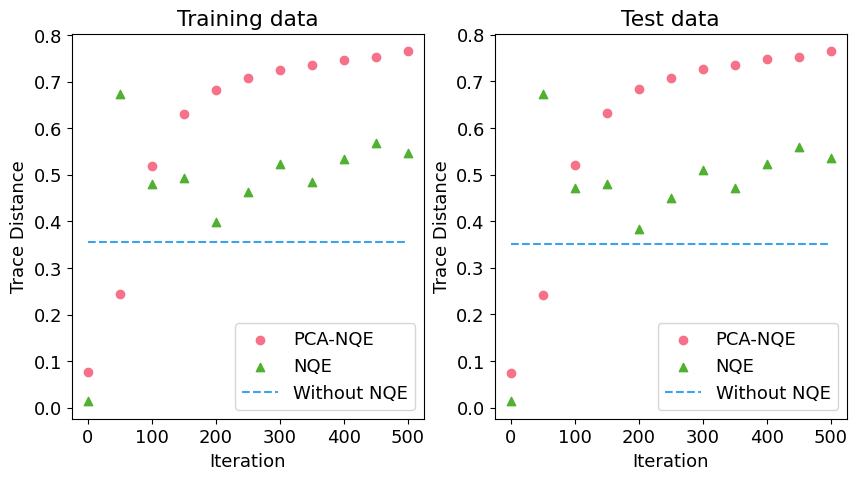

In [12]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, (ax1, ax2) = plt.subplots(1,2)
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    ax1.scatter(np.array(range(11)) * 50, D_with_PCA_NQE_Train, label="PCA-NQE", c=clrs[0])
    ax1.scatter(np.array(range(11)) * 50, D_with_NQE_Train, label="NQE", c=clrs[1], marker='^')
    ax1.plot(np.array(range(11)) * 50, np.ones(11) * D_without_NQE_Train, linestyle='dashed', linewidth=1.5, label="Without NQE", c=clrs[2])
    
    ax2.scatter(np.array(range(11)) * 50, D_with_PCA_NQE_Test, label="PCA-NQE", c=clrs[0])
    ax2.scatter(np.array(range(11)) * 50, D_with_NQE_Test, label="NQE", c=clrs[1], marker='^')
    ax2.plot(np.array(range(11)) * 50, np.ones(11) * D_without_NQE_Test, linestyle='dashed', linewidth=1.5, label="Without NQE", c=clrs[2])

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Trace Distance")
ax1.set_title("Training data")
ax1.legend()

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Trace Distance")
ax2.set_title("Test data")
ax2.legend()
plt.savefig("Trace Distance History.pdf")

## 5.QKM Generalization

In [5]:
model2 = x_transform2()
model3 = x_transform3()

model2.load_state_dict(torch.load("PCA-NQE500.pt"))
model3.load_state_dict(torch.load("NQE500.pt"))

<All keys matched successfully>

In [6]:
dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev)
def overlap_circuit1(x1,x2):
    embedding.Noisy_Four_QuantumEmbedding1(x1)
    embedding.Noisy_Four_QuantumEmbedding1_inverse(x2)
    return qml.probs(wires=range(4))

@qml.qnode(dev)
def overlap_circuit2(x1,x2):
    embedding.Noisy_Four_QuantumEmbedding2(x1)
    embedding.Noisy_Four_QuantumEmbedding2_inverse(x2)
    return qml.probs(wires=range(4))

def kernel(x1, x2, NQE):
    if NQE == False:
        kernel = overlap_circuit1(x1,x2)
    
    
    elif NQE == 'PCA-NQE':
        x1 = model2(torch.tensor(x1))
        x2 = model2(torch.tensor(x2))
        kernel = overlap_circuit2(x1, x2)

    elif NQE == 'NQE':
        x1 = model3(torch.tensor(x1))[0]
        x2 = model3(torch.tensor(x2))[0]
        kernel = overlap_circuit2(x1,x2)
    
    return kernel

In [7]:
def get_error_bound(weights, Kernel):
    error_list = []
    for weight in weights:
        Kernel_MP = np.linalg.pinv(Kernel + weight * np.eye(N), hermitian = True)
        error_list.append(np.sqrt(Y_train @ Kernel_MP @ Kernel @ Kernel_MP @ Y_train.T / N))
        
    error_list = np.array(error_list)

    return error_list

In [8]:
for k in range(5):
    print(k)
    feature_reduction = 'PCA4'
    classes = [0,1]
    X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
    Y_train = [-1 if y == 0 else 1 for y in Y_train]
    Y_test = [-1 if y == 0 else 1 for y in Y_test]
    Y_train = np.array(Y_train)
    N = 1000
    X_train = X_train[k * N: (k + 1) * N]
    Y_train = Y_train[k * N: (k + 1) * N]

    Kernel0 = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            x = kernel(X_train[i], X_train[j], False)
            Kernel0[i][j] = x[0]
            Kernel0[j][i] = x[0]

    weights = np.arange(0.1 , 1, 0.1)
    error_list = get_error_bound(weights, Kernel0)
    f = open("generalization.txt", 'a')
    f.write("\n")
    f.write(f"Generalization Error bounds list {k}\n")
    f.write(str(error_list))
    f.close()

    Kernel_rank = np.linalg.matrix_rank(Kernel0)
    Kernel_offD = []
    for i in range(N):
        for j in range(i + 1, N):
            Kernel_offD.append(Kernel0[i][j])

    Kernel_offD = np.array(Kernel_offD)
    Kernel_element_variance = Kernel_offD.std()**2

    f = open("Kernel Rank & Variance.txt", 'a')
    f.write("\n")
    f.write(f"Kernel0 iter {k}\n")
    f.write(f"Kernel Rank: {Kernel_rank}\n")
    f.write(f"Kernel Variance: {Kernel_element_variance}\n")
    f.close()

0
1
2
3
4


In [9]:
for k in range(5):
    print(k)
    feature_reduction = 'PCA4'
    classes = [0,1]
    X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
    Y_train = [-1 if y == 0 else 1 for y in Y_train]
    Y_test = [-1 if y == 0 else 1 for y in Y_test]
    Y_train = np.array(Y_train)
    
    N = 1000
    X_train = X_train[k * N: (k + 1) * N]
    Y_train = Y_train[k * N: (k + 1) * N]

    Kernel2 = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            x = kernel(X_train[i], X_train[j], "PCA-NQE")
            Kernel2[i][j] = x[0]
            Kernel2[j][i] = x[0]

    weights = np.arange(0.1 , 1, 0.1)
    error_list = get_error_bound(weights, Kernel2)
    f = open("generalization.txt", 'a')
    f.write("\n")
    f.write(f"Generalization Error bounds list (PCA-NQE) {k}\n")
    f.write(str(error_list))
    f.close()

    Kernel_rank = np.linalg.matrix_rank(Kernel2)
    Kernel_offD = []
    for i in range(N):
        for j in range(i + 1, N):
            Kernel_offD.append(Kernel2[i][j])

    Kernel_offD = np.array(Kernel_offD)
    Kernel_element_variance = Kernel_offD.std()**2

    f = open("Kernel Rank & Variance.txt", 'a')
    f.write("\n")
    f.write(f"Kernel2 iter {k}\n")
    f.write(f"Kernel Rank: {Kernel_rank}\n")
    f.write(f"Kernel Variance: {Kernel_element_variance}\n")
    f.close()

0
1
2
3
4


In [10]:
for k in range(5):
    print(k)
    
    classes = [0,1]
    feature_reduction = False
    X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
    X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
    X_train, X_test = X_train.permute(0,3,1,2).detach().numpy(), X_test.permute(0,3,1,2).detach().numpy()
    Y_train = [-1 if y == 0 else 1 for y in Y_train]
    Y_test = [-1 if y == 0 else 1 for y in Y_test]
    Y_train = np.array(Y_train)

    N = 1000
    X_train = X_train[k * N: (k + 1) * N]
    Y_train = Y_train[k * N: (k + 1) * N]

    Kernel3 = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            x = kernel(X_train[i], X_train[j], "NQE")
            Kernel3[i][j] = x[0]
            Kernel3[j][i] = x[0]

    weights = np.arange(0.1 , 1, 0.1)
    error_list = get_error_bound(weights, Kernel3)
    f = open("generalization.txt", 'a')
    f.write("\n")
    f.write(f"Generalization Error bounds list (NQE) {k}\n")
    f.write(str(error_list))
    f.close()

    Kernel_rank = np.linalg.matrix_rank(Kernel3)
    Kernel_offD = []
    for i in range(N):
        for j in range(i + 1, N):
            Kernel_offD.append(Kernel3[i][j])

    Kernel_offD = np.array(Kernel_offD)
    Kernel_element_variance = Kernel_offD.std()**2

    f = open("Kernel Rank & Variance.txt", 'a')
    f.write("\n")
    f.write(f"Kernel3 iter {k}\n")
    f.write(f"Kernel Rank: {Kernel_rank}\n")
    f.write(f"Kernel Variance: {Kernel_element_variance}\n")
    f.close()

0
1
2
3
4


In [2]:
weights = np.arange(0.1, 1, 0.1)
error_list0 = [0.25170087, 0.22658288, 0.21252565, 0.20277865, 0.19528545, 0.18917741,
 0.18401027, 0.17952653, 0.17556327, 0.25077325, 0.23064637, 0.21856657, 0.20961595, 0.20240508, 0.1963319,
 0.19107242, 0.18642876, 0.18226975, 0.27861743, 0.25133426, 0.2353028 , 0.22401216, 0.21529313, 0.20817729,
 0.20215447, 0.19692497, 0.1922984 , 0.30006864, 0.26924144, 0.2490177 , 0.23404082, 0.22224529, 0.21258763,
 0.2044625 , 0.19748661, 0.19140197, 0.25581136, 0.22827293, 0.21306417, 0.20279657, 0.19512452, 0.18902035,
 0.18395281, 0.17961626, 0.17582081]
error_list2 = [0.16834589, 0.12615699, 0.10701142, 0.09570304, 0.08815965, 0.08274154,
 0.07864684, 0.07543389, 0.07283867, 0.17375446, 0.13744866, 0.1199372 , 0.10869681, 0.1006031 , 0.09440068,
 0.08945548, 0.08540144, 0.08200799, 0.16360519, 0.116192  , 0.09849763, 0.08896527, 0.08289796, 0.07864079,
 0.07545435, 0.07295691, 0.07093094, 0.15952886, 0.12788042, 0.11223303, 0.10228933, 0.09523739, 0.089906,
 0.08570041, 0.08228009, 0.07943343, 0.15368787, 0.11524353, 0.0991112 , 0.08974101, 0.08343344, 0.07881762,
 0.07525435, 0.07239974, 0.07004981]
error_list3 = [0.15326398, 0.10861177, 0.09085593, 0.08131029, 0.07534797, 0.07126051,
 0.06827355, 0.06598706, 0.06417431, 0.14721212, 0.10921554, 0.0952174 , 0.08753594, 0.08246583, 0.0787618,
 0.07588305, 0.0735526 , 0.0716114 ,0.17202017 ,0.1216615  ,0.10191293 ,0.09125234 ,0.08446463 ,0.07968975,
 0.07610521, 0.07329109, 0.07100948, 0.16785958, 0.12000654, 0.10091035, 0.09042699, 0.08369758, 0.07895477,
 0.07539939, 0.07261594, 0.07036606, 0.17378142, 0.12075123, 0.10055146, 0.08991244, 0.08328485, 0.07870471,
 0.07531162, 0.07267185, 0.07054338]
error_list0, error_list2, error_list3 = np.array(error_list0), np.array(error_list2), np.array(error_list3)
error_list0 = error_list0.reshape(5,9)
error_list2 = error_list2.reshape(5,9)
error_list3 = error_list3.reshape(5,9)

error_list0_mean, error_list0_std = error_list0.mean(axis=0), error_list0.std(axis=0)
error_list2_mean, error_list2_std = error_list2.mean(axis=0), error_list2.std(axis=0)
error_list3_mean, error_list3_std = error_list3.mean(axis=0), error_list3.std(axis=0)

/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_1905/1315228976.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(weights, error_list2_mean, label="PCA-NQE", marker="o", c=clrs[0])
/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_1905/1315228976.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(weights, error_list3_mean, label="NQE", marker="^", c=clrs[1])
/var/folders/s2/t3n8

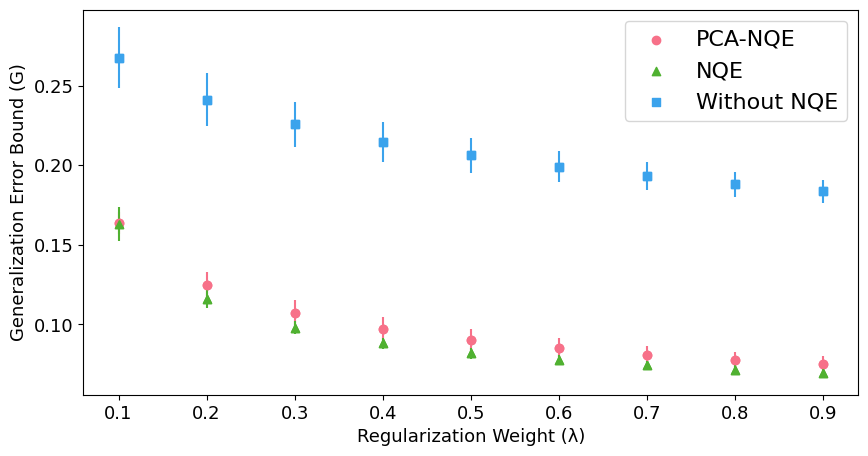

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    
    ax.scatter(weights, error_list2_mean, label="PCA-NQE", marker="o", c=clrs[0])
    ax.scatter(weights, error_list3_mean, label="NQE", marker="^", c=clrs[1])
    ax.scatter(weights, error_list0_mean, label="Without NQE", marker="s", c=clrs[2])
    
    
    ax.errorbar(weights, error_list2_mean, yerr=error_list2_std, fmt="o", c=clrs[0])
    ax.errorbar(weights, error_list3_mean, yerr=error_list3_std, fmt="^", c=clrs[1])
    ax.errorbar(weights, error_list0_mean, yerr=error_list0_std, fmt="s", c=clrs[2])

ax.set_xlabel("Regularization Weight (λ)")
ax.set_ylabel("Generalization Error Bound (G)")
#ax.set_title("Generalization Error Bounds against Regularization Weights")
ax.legend(fontsize=16)
plt.savefig("QKM Generalization.pdf")

## Expressibility and Kernel Variance

In [14]:
def random_unitary(n):
    """
        Return a Haar distributed random unitary from U(N)
    """

    Z = np.random.randn(2**n, 2**n) + 1.0j * np.random.randn(2**n, 2**n)
    [Q, R] = np.linalg.qr(Z)
    D = np.diag(np.diagonal(R) / np.abs(np.diagonal(R)))
    return np.dot(Q, D)

def haar_integral(num_qubits, samples):
    """
        Return calculation of Haar Integral for a specified number of samples.
    """

    n = num_qubits
    randunit_density = np.zeros((4**n, 4**n), dtype=complex)

    
    zero_state = np.zeros(4**n, dtype=complex)
    zero_state[0] = 1
    
    for _ in range(samples):
        U = random_unitary(n)
        U = np.kron(U,U)
        A = np.matmul(zero_state, U).reshape(-1,1)
        randunit_density += np.kron(A, A.conj().T) 

    randunit_density/=samples

    return randunit_density

In [18]:
def kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

dev_sim = qml.device('default.qubit', wires=4)
@qml.qnode(dev_sim, interface="torch")
def circuit2(inputs): 
    embedding.Noisy_Four_QuantumEmbedding2(inputs)
    return qml.density_matrix(wires=range(4))

@qml.qnode(dev_sim, interface="torch")
def circuit1(inputs): 
    embedding.Noisy_Four_QuantumEmbedding1(inputs)
    return qml.density_matrix(wires=range(4))


class exp0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer0 = qml.qnn.TorchLayer(circuit1, weight_shapes={})

    def forward(self, x):
        rhos = self.qlayer0(x)
        rhos = kron(rhos, rhos)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(4, len(x)))
        return exp**2
    
    
class exp2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(circuit2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        rhos = self.qlayer2(x)
        rhos = kron(rhos, rhos)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(4, len(x)))
        return exp**2


class exp3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(circuit2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        rhos = self.qlayer3(x)
        rhos = kron(rhos, rhos)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(4, len(x)))
        return exp**2

In [19]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
X_test =  torch.tensor(X_test).to(torch.float32)
X_train = torch.tensor(X_train).to(torch.float32)

In [20]:
model0 = exp0()
model2 = exp2()
model2.load_state_dict(torch.load("PCA-NQE500.pt"))
exp_model0_train = model0(X_train)
exp_model0_test = model0(X_test)
print(f"Without NQE Expressibility Train Data: {exp_model0_train}")
print(f"Without NQE Expressibility Test Data: {exp_model0_test}")
exp_model2_train = model2(X_train)
exp_model2_test = model2(X_test)
print(f"PCA-NQE Expressibility Train Data: {exp_model2_train}")
print(f"PCA-NQE Expressibility Test Data: {exp_model2_test}")

Without NQE Expressibility Train Data: 0.02153831654716162
Without NQE Expressibility Test Data: 0.0210191438662581
PCA-NQE Expressibility Train Data: 0.14846898326058927
PCA-NQE Expressibility Test Data: 0.14872366921137778


In [21]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)

In [22]:
model3 = exp3()
model3.load_state_dict(torch.load("NQE500.pt"))
exp_model3_train = model3(X_train)
exp_model3_test = model3(X_test)
print(f"PCA-NQE Expressibility Train Data: {exp_model3_train}")
print(f"PCA-NQE Expressibility Test Data: {exp_model3_test}")

PCA-NQE Expressibility Train Data: 0.24827184542851746
PCA-NQE Expressibility Test Data: 0.2488509831413183


In [5]:
Kernel0_variance = [0.023761891165071127, 0.02400229219659251, 0.02387813056932932, 0.024715612208930985, 0.023522675239445012]
Kernel2_variance = [0.14685024365098165, .144520228042596, 0.14370200943377406, 0.14730151462503513, 0.14485868604001542]
Kernel3_variance = [0.16522643158967862, 0.1611593306872936, 0.16314209977977637, 0.16407594346304913, 0.161477382222486]

Kernel0_variance = np.array(Kernel0_variance)
Kernel2_variance = np.array(Kernel2_variance)
Kernel3_variance = np.array(Kernel3_variance)

exp0_train = 0.02153831654716162
exp0_test = 0.0210191438662581
exp2_train = 0.14846898326058927
exp2_test = 0.14872366921137778
exp3_train = 0.24827184542851746
exp3_test = 0.2488509831413183

print(np.sqrt(exp0_train), np.sqrt(exp0_test), np.sqrt(exp2_train), np.sqrt(exp2_test), np.sqrt(exp3_train), np.sqrt(exp3_test), )

0.14675938316564846 0.1449798050290388 0.3853167310935113 0.3856470785723364 0.4982688485431509 0.498849659858878


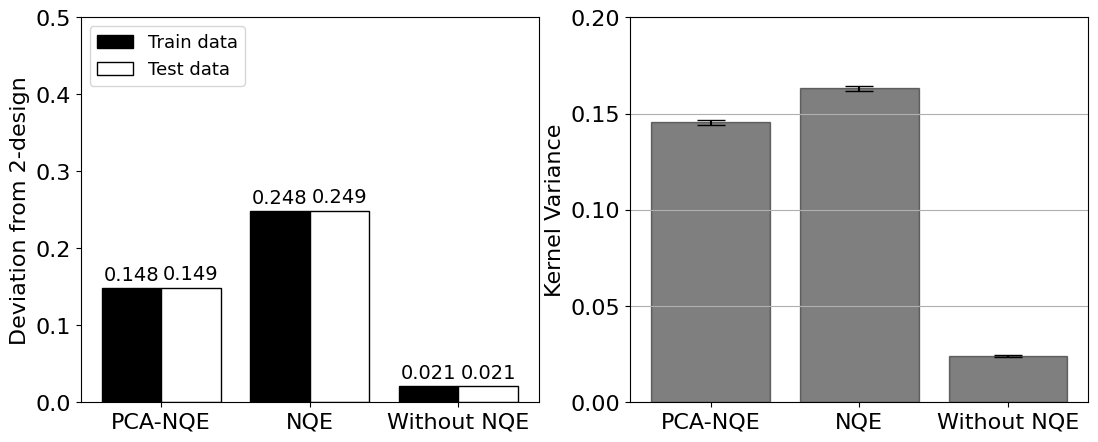

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 5]
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(1,2)
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    X = ("PCA-NQE", "NQE", "Without NQE",)
    expressibility = {
        'Train data': (0.148, 0.248, 0.021),
        'Test data': (0.149, 0.249, 0.021),
    }
    Kernel_Variance = {
        'Kernel_Variance': (Kernel0_variance.mean(), Kernel2_variance.mean(), 
                            Kernel3_variance.mean())
    }

x = np.arange(len(X))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0


for attribute, measurement in expressibility.items():
    if attribute == 'Train data':
        color = "black"
    else:
        color = "white"
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=attribute, color=color, edgecolor='black')
    ax1.bar_label(rects, padding=3, fontsize=14)
    multiplier += 1

#x = np.arange(len(X))  # the label locations
#width = 0.25 # the width of the bars
#multiplier = 0

#for attribute, measurement in Kernel_Variance.items():
#    if attribute == 'Kernel_Variance':
#        color = "white"
#    else:
#        color = "white"
#    offset = width * multiplier
#    rects = ax2.bar(x + offset, measurement, width, label=attribute, color=color, edgecolor='black')
#    ax2.bar_label(rects,padding=3, fontsize=10)
#    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Deviation from 2-design')
#ax1.set_title('Expressibility')
ax1.set_xticks(x + width - 0.2, X)
ax1.legend(loc='upper left', ncols=1, fontsize=13)
ax1.set_ylim(0, 0.5)

x_pos = np.arange(3)
y = [Kernel2_variance.mean(), Kernel3_variance.mean(), Kernel0_variance.mean()]
error = [Kernel2_variance.std(), Kernel3_variance.std(), Kernel0_variance.std()]
ax2.bar(x_pos, y, yerr=error, align='center', alpha=0.5, color='black', edgecolor='black',ecolor='black', capsize=10)
ax2.set_ylabel('Kernel Variance')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(X)
#ax2.set_title('Kernel Variance')
ax2.set_yticks([0,0.05,0.1,0.15, 0.2])
ax2.yaxis.grid(True)
#ax2.set_ylabel('Kernel Variance')
#ax2.set_title('Kernel Variance')
#ax2.set_xticks(x + width - 0.25, X)
#ax2.set_ylim(0, 0.5)
plt.savefig("Expressibility.pdf")